## Zonal means of anthropogenic carbon in the ocean
### Zonal means of differences in DIC and DIC_ALT_CO2 in 2015 (the beginning of SSP2-4.5)

* "ALT_CO2" variables represent the ocean carbonate system held under constant PI CO$_2$ levels.
* Differencing `DIC` and `DIC_ALT_CO2` creates anthropogenic `DIC` in the ocean.

##### Run using the NPL 2023a environment

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import pop_tools 
import utils_ocean as utils
xr.set_options(keep_attrs=True)

### define case and path

In [2]:
case = 'b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001'
path = '/glade/campaign/cesm/community/bgcwg/HOPE/' + case + '/ocn/proc/tseries/month_1'

### Get future SSP2-4.5 HOPE 001 ensemble member

In [3]:
variables = ['DIC','DIC_ALT_CO2','PD'] 

files = []
year = 2100

yr4="{:04d}".format(year)

for var in variables:

    files.extend(sorted(glob(f'{path}/{case}.pop.h.{var}.201501-210012.nc')))


ds = xr.open_mfdataset(files,decode_times=True,decode_coords=False, combine='nested')

In [4]:
keep_vars = ['z_t','z_t_150m','time_bound','TAREA','time',
             'REGION_MASK','dz','KMT','TLONG','TLAT'] + variables

ds = ds.drop([v for v in ds.variables if v not in keep_vars])

In [5]:
ds = ds.isel(time=slice(0,12)).mean(dim='time', keep_attrs=True)

### Use pop tools to get ocean grid info

In [6]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m2 = area * 1.e-4
dz_m = ds_grid.dz * 0.01

#ds_grid.to_netcdf('/glade/derecho/scratch/kristenk/POP_gx1v7.nc')

### Use Keith's method of computing zonal means

In [7]:
for var in variables:
    attrs = ds[var].attrs
    np_array = ds[var].values
    ds[var] = xr.DataArray(np_array.astype('float64'),dims=('z_t','nlat','nlon'))
    ds[var].attrs = attrs

In [8]:
ds

<xarray.Dataset>
Dimensions:      (z_t: 60, z_t_150m: 15, nlat: 384, nlon: 320)
Coordinates:
  * z_t          (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m     (z_t_150m) float32 500.0 1.5e+03 2.5e+03 ... 1.35e+04 1.45e+04
Dimensions without coordinates: nlat, nlon
Data variables:
    dz           (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    TLONG        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT         (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    KMT          (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    REGION_MASK  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TAREA        (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DIC          (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    DIC_ALT_CO2  (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
    PD           (z_t, nlat, nlon) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    title:             b.e21.BSSP245.f09_g17.hopens-reference.esmfirebvoc.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2024-08-21 at 12:43:47.4
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [9]:
rmask_file = os.path.join(os.path.sep,
                          'glade',
                          'campaign',
                          'cgd',
                          'oce',
                          'people',
                          'klindsay',
                          'oldcgdoce',
                          'REGION_MASK',
                          'new_REGION_MASK_gx1v6.nc')

da_zonal_mean = dict()
for var in variables:
    print('doing variable:', var)
    ds_tmp = utils.zonal_mean_via_fortran(ds, var, grid='gx1v7',rmask_file=rmask_file)
    print('ran za')
    da_zonal_mean[var] = ds_tmp[var].compute()

doing variable: DIC
Wrote dataset to /glade/derecho/scratch/kristenk/tmp/tmpe1g0a1u7.nc
za ran successfully, writing netcdf output
ran za
doing variable: DIC_ALT_CO2
Wrote dataset to /glade/derecho/scratch/kristenk/tmp/tmpvxopx2as.nc
za ran successfully, writing netcdf output
ran za
doing variable: PD
Wrote dataset to /glade/derecho/scratch/kristenk/tmp/tmp8d4r18pd.nc
za ran successfully, writing netcdf output
ran za


In [10]:
da_zonal_mean.keys()

dict_keys(['DIC', 'DIC_ALT_CO2', 'PD'])

### Set up variables for global zonal mean plot

In [11]:
DIC_diff_zonal = da_zonal_mean['DIC'].isel(basins=0) - da_zonal_mean['DIC_ALT_CO2'].isel(basins=0)

DIC_zonal_top = DIC_diff_zonal.isel(z_t=slice(0,40))
DIC_zonal_bottom = DIC_diff_zonal.isel(z_t=slice(40,60))

lats = da_zonal_mean['DIC'].lat_t.values
depths = da_zonal_mean['DIC'].z_t.values * 0.01

z_top=depths[0:40]
z_bottom=depths[40:60]

zonal_pdens = da_zonal_mean['PD'].isel(basins=0) * 1000. - 1000.

pdens_zonal_top = zonal_pdens.isel(z_t=slice(0,40))
pdens_zonal_bottom = zonal_pdens.isel(z_t=slice(40,60))

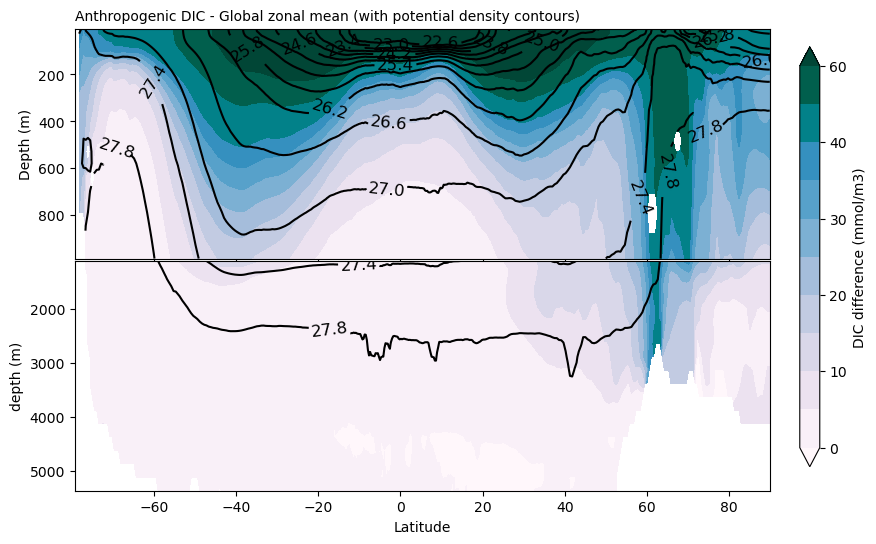

In [12]:
levels = [0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]
cmap = 'PuBuGn'

fig = plt.figure(figsize=(10,6))

ax = fig.add_subplot(2,1,1)
ax.set_title('Anthropogenic DIC - Global zonal mean (with potential density contours)',loc='left',fontsize=10)

pc=ax.contourf(lats, z_top, DIC_zonal_top, levels, cmap=cmap,extend='both')
contour = plt.contour(lats, z_top, pdens_zonal_top, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='Depth (m)')
ax.invert_yaxis()

ax = fig.add_subplot(2,1,2)
pc=ax.contourf(lats, z_bottom, DIC_zonal_bottom, levels, cmap=cmap,extend='both')
contour = plt.contour(lats, z_bottom, pdens_zonal_bottom, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

fig.subplots_adjust(right=0.82,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, extend='max', label='DIC difference (mmol/m3)')

### Set up variables for basin plots

### For zonal means dataset:
#### * Pacific basin (basin = 1)
#### * Atlantic basin (basin = 3)
#### * Indian basin (basin = 2)

In [13]:
DIC_diff_zonal_pac = da_zonal_mean['DIC'].isel(basins=1) - da_zonal_mean['DIC_ALT_CO2'].isel(basins=1)
DIC_diff_zonal_ind = da_zonal_mean['DIC'].isel(basins=2) - da_zonal_mean['DIC_ALT_CO2'].isel(basins=2)
DIC_diff_zonal_atl = da_zonal_mean['DIC'].isel(basins=3) - da_zonal_mean['DIC_ALT_CO2'].isel(basins=3)

DIC_zonal_top_pac = DIC_diff_zonal_pac.isel(z_t=slice(0,40))
DIC_zonal_bottom_pac = DIC_diff_zonal_pac.isel(z_t=slice(40,60))
DIC_zonal_top_ind = DIC_diff_zonal_ind.isel(z_t=slice(0,40))
DIC_zonal_bottom_ind = DIC_diff_zonal_ind.isel(z_t=slice(40,60))
DIC_zonal_top_atl = DIC_diff_zonal_atl.isel(z_t=slice(0,40))
DIC_zonal_bottom_atl = DIC_diff_zonal_atl.isel(z_t=slice(40,60))

lats = da_zonal_mean['DIC'].lat_t.values
depths = da_zonal_mean['DIC'].z_t.values * 0.01

z_top=depths[0:40]
z_bottom=depths[40:60]

zonal_pdens_pac = da_zonal_mean['PD'].isel(basins=1) * 1000. - 1000.
zonal_pdens_ind = da_zonal_mean['PD'].isel(basins=2) * 1000. - 1000.
zonal_pdens_atl = da_zonal_mean['PD'].isel(basins=3) * 1000. - 1000.

pdens_zonal_top_pac = zonal_pdens_pac.isel(z_t=slice(0,40))
pdens_zonal_bottom_pac = zonal_pdens_pac.isel(z_t=slice(40,60))
pdens_zonal_top_ind = zonal_pdens_ind.isel(z_t=slice(0,40))
pdens_zonal_bottom_ind = zonal_pdens_ind.isel(z_t=slice(40,60))
pdens_zonal_top_atl = zonal_pdens_atl.isel(z_t=slice(0,40))
pdens_zonal_bottom_atl = zonal_pdens_atl.isel(z_t=slice(40,60))

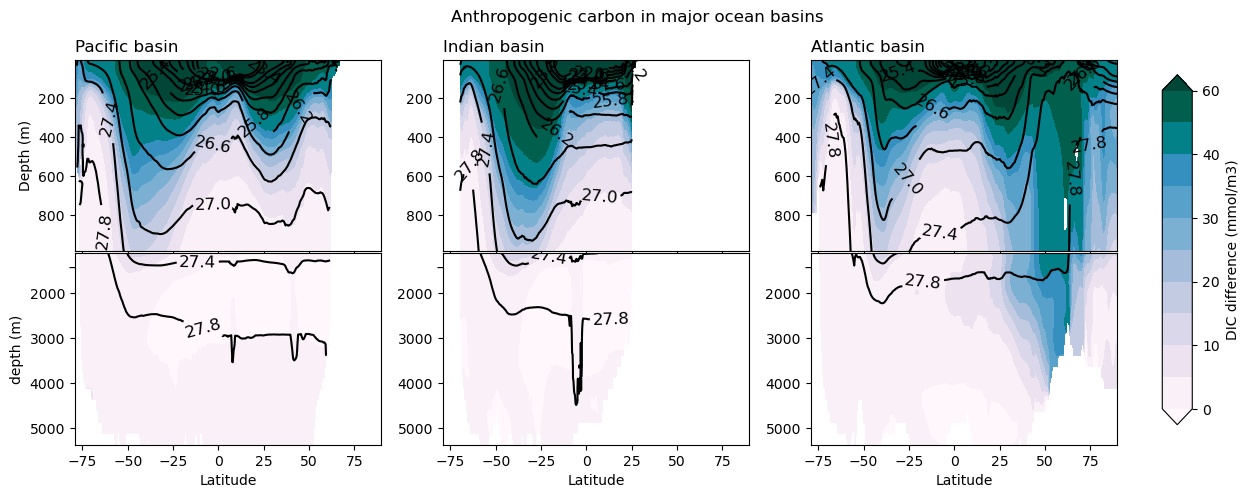

In [14]:
levels = [0,5,10,15,20,25,30,35,40,50,60]
sigma_levels = [22.6, 23., 23.4, 23.8,24.2, 24.6, 25., 25.4, 25.8, 26.2, 26.6, 27., 27.4, 27.8, 28.2]
cmap = 'PuBuGn'

fig = plt.figure(figsize=(15,5))
fig.suptitle('Anthropogenic carbon in major ocean basins')

##################### Pacific plot
ax = fig.add_subplot(2,3,1)
ax.set_title('Pacific basin',loc='left',fontsize=12)

pc=ax.contourf(lats, z_top, DIC_zonal_top_pac, levels, cmap=cmap, extend='both')
contour = plt.contour(lats, z_top, pdens_zonal_top_pac, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='Depth (m)')
ax.invert_yaxis()

ax = fig.add_subplot(2,3,4)
pc=ax.contourf(lats, z_bottom, DIC_zonal_bottom_pac, levels, cmap=cmap, extend='both')
contour = plt.contour(lats, z_bottom, pdens_zonal_bottom_pac, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(ylabel='depth (m)', xlabel='Latitude')
ax.invert_yaxis()

##################### Indian plot
ax = fig.add_subplot(2,3,2)
ax.set_title('Indian basin',loc='left',fontsize=12)

pc=ax.contourf(lats, z_top, DIC_zonal_top_ind, levels, cmap=cmap, extend='both')
contour = plt.contour(lats, z_top, pdens_zonal_top_ind, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,3,5)
pc=ax.contourf(lats, z_bottom, DIC_zonal_bottom_ind, levels, cmap=cmap, extend='both')
contour = plt.contour(lats, z_bottom, pdens_zonal_bottom_ind, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()

##################### Atlantic plot
ax = fig.add_subplot(2,3,3)
ax.set_title('Atlantic basin',loc='left',fontsize=12)

pc=ax.contourf(lats, z_top, DIC_zonal_top_atl, levels, cmap=cmap, extend='both')
contour = plt.contour(lats, z_top, pdens_zonal_top_atl, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.invert_yaxis()

ax = fig.add_subplot(2,3,6)
pc=ax.contourf(lats, z_bottom, DIC_zonal_bottom_atl, levels, cmap=cmap, extend='both')
contour = plt.contour(lats, z_bottom, pdens_zonal_bottom_atl, sigma_levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
ax.set(xlabel='Latitude')
ax.invert_yaxis()


fig.subplots_adjust(right=0.82,hspace=0.01)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(pc, cax=cbar_ax, extend='max', label='DIC difference (mmol/m3)')